# IMPORTS 

In [106]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(12)

import warnings
warnings.filterwarnings('ignore')

# DATA LOADING AND PROCESSING 

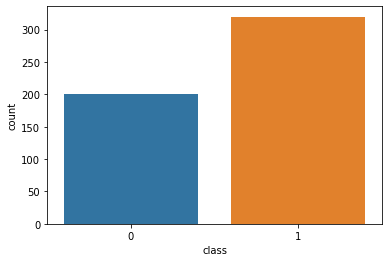

In [107]:
## loading data
data = pd.read_csv("diabetes_data_upload (1).csv")

## encdoing categorical columns
label_encoder = LabelEncoder()
for column in data.columns:
    data[column] = label_encoder.fit_transform(data[column])
    
## scaling age column
scaler = MinMaxScaler()
data["Age"] = scaler.fit_transform(data[['Age']])

## Seperating data and lables
X = data.drop(["class"], axis = 1)
y = data["class"]

## plotting class labels count plot 
fig = sns.countplot(y);

# SPLITING DATA TO TRAIN, VALID AND TEST SET 

In [108]:
## Spliting data to train and test splits 
X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size = 0.2, random_state = 12)
## Spliting train data further to validation split 
X_train, X_valid, y_train, y_valid =  train_test_split(X_train, y_train, test_size = 0.2, random_state = 12)
## converting numpy arrays to  pytorch tensors 
X_train = torch.tensor(X_train.values, dtype=torch.float64,  device =device )
y_train = torch.tensor(y_train.values, dtype=torch.float64,  device =device)
X_valid = torch.tensor(X_valid.values, dtype=torch.float64, device =device)
y_valid = torch.tensor(y_valid.values, dtype=torch.float64, device =device)
X_test = torch.tensor(X_test.values, dtype=torch.float64, device =device)
y_test = torch.tensor(y_test.values, dtype=torch.float64, device =device)

<h1>(i) WITHOUT HYPER PARAMAETER TUNING</h1>

# DEFINING MODEL 

In [109]:
## defining model class
# one input layer, one hidden layer and one ouput layer
class MLP(nn.Module):
    def __init__(self, dropout_prob,in_features, out_features ):
        super(MLP, self).__init__()
        ## dropout probability
        self.dropout_prob = dropout_prob
        self.dropout = nn.Dropout(p=dropout_prob)
        
        ## linear layers 
        self.layer_1 = nn.Linear(in_features, 2*in_features) 
        self.layer_2 = nn.Linear(2*in_features, out_features)
        
        ## activation layers
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    ## forward call of model     
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.sigmoid(x)
        return x

## defining accuracy metric
def accuracy(ouputs,labels):
    preds = ouputs.squeeze().numpy()
    preds = preds.round().astype("int")
    labels = labels.numpy().astype("int")
    return accuracy_score(labels, preds)

# TRAINING 

In [110]:
## hyperparameters
DROPOUT = 0.2
LEARNING_RATE = 0.005
EPOCHS = 40
B1 = 0.5

## defining input and output shapes
in_features = X_train.shape[1]
out_features = 1 ## binary_classification

## nstantiating model
model = MLP(DROPOUT,in_features, out_features)

## sending mode to device (GPU/CPU)
model.to(device)

## defining loss and optmizier
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(B1, 0.999)) 

train_losses = []
train_accuarcies = []
test_losses = []
test_accuarcies = []

## training for previously defined number of epochs
for epoch in range(EPOCHS):
    
    ## training on train set
    out = model(X_train.float())
    loss = criterion(out.squeeze(),y_train)
    train_acc = accuracy(out.detach().cpu(),y_train.cpu())
    train_losses.append(loss.cpu().item())
    train_accuarcies.append(train_acc)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    ## verbosity progress print
    if (epoch+1)%10 == 0 or epoch ==0 :
        print(f"EPOCH = {(epoch+1):>3.0f},     Train loss = {(loss):>0.2f},    Train acc = {(train_acc):>0.2f}, ", )

EPOCH =   1,     Train loss = 0.67,    Train acc = 0.38, 
EPOCH =  10,     Train loss = 0.65,    Train acc = 0.71, 
EPOCH =  20,     Train loss = 0.62,    Train acc = 0.83, 
EPOCH =  30,     Train loss = 0.60,    Train acc = 0.89, 
EPOCH =  40,     Train loss = 0.59,    Train acc = 0.90, 


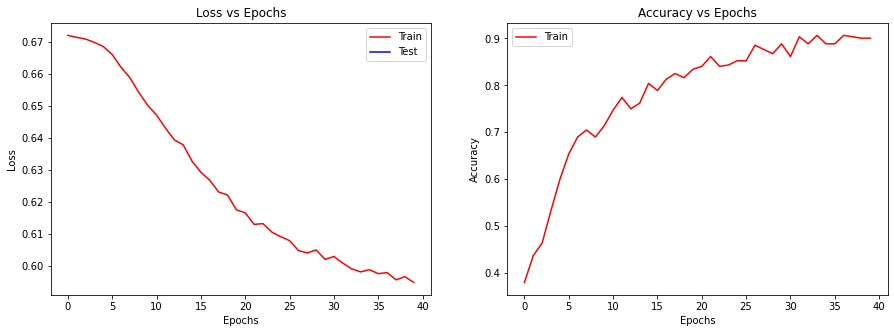

In [111]:
## Accuracy and Loss curve
fig,ax = plt.subplots(1,2, figsize= (15,5))

ax[0].plot(train_losses, label = "Train", color = "red")
ax[0].plot(test_losses, label = "Test", color = 'blue')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss vs Epochs")
ax[0].legend()

ax[1].plot(train_accuarcies, label = "Train", color = "red")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy vs Epochs")
ax[1].legend()
fig.show()

<h1>(ii) HYPER PARAMETER TUNING </h1> 

## Effect of number of hidden layers 

In [112]:
## defining 2 new models
## one input layer, 2 hidden layers and one output layer
class MLP_3(nn.Module):
    def __init__(self, dropout_prob,in_features, out_features ):
        super(MLP_3, self).__init__()
        self.dropout_prob = dropout_prob
        self.layer_1 = nn.Linear(in_features, 2*in_features) 
        self.layer_2 = nn.Linear(2*in_features, 4*in_features) 
        self.layer_3 = nn.Linear(4*in_features, out_features)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.dropout(x)
        x = self.layer_3(x)
        x = self.sigmoid(x)
        return x

## one input layer, 3 hidden layers, and one output layer
class MLP_4(nn.Module):
    def __init__(self, dropout_prob,in_features, out_features ):
        super(MLP_4, self).__init__()
        self.dropout_prob = dropout_prob
        self.layer_1 = nn.Linear(in_features, 2*in_features) 
        self.layer_2 = nn.Linear(2*in_features, 4*in_features) 
        self.layer_3 = nn.Linear(4*in_features, 8*in_features)
        self.layer_4 = nn.Linear(8*in_features, out_features)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.dropout(x)
        x = self.relu(self.layer_3(x))
        x = self.dropout(x)
        x = self.layer_4(x)
        x = self.sigmoid(x)
        return x
    
        
def accuracy(ouputs,labels):
    preds = ouputs.squeeze().numpy()
    preds = preds.round().astype("int")
    labels = labels.numpy().astype("int")
    return accuracy_score(labels, preds)


## hyperparameters
DROPOUT = 0.2
LEARNING_RATE = 0.005
EPOCHS = 40
in_features = X_train.shape[1]
out_features = 1 
B1 = 0.5
i = 3
## iterating over all three models and generating test set accuracy 
models = [ MLP(DROPOUT,in_features, out_features), MLP_3(DROPOUT,in_features, out_features), MLP_4(DROPOUT,in_features, out_features) ]
for model in models:
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE,betas=(B1, 0.999)) 
 

    train_losses = []
    train_accuarcies = []
    valid_losses = []
    valid_accuarcies = []
    for epoch in range(EPOCHS):
        out = model(X_train.float())
        loss = criterion(out.squeeze(),y_train)
        train_acc = accuracy(out.detach().cpu(),y_train.cpu())
        train_losses.append(loss.cpu().item())
        train_accuarcies.append(train_acc)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        with torch.no_grad():
            pred = model(X_valid.float())
            valid_loss = criterion(pred.squeeze(),y_valid)
            valid_acc = accuracy(pred.cpu(),y_valid.cpu())
            valid_losses.append(valid_loss.cpu().item())
            valid_accuarcies.append(valid_acc)
    model.eval()
    with torch.no_grad():
        preds = model(X_valid.float())
        preds = preds.squeeze().cpu().numpy().round().astype("int")
    labels = y_valid.cpu().numpy()
    print(f" Number of layers: {i}, Validation-Set Accuracy =  {(accuracy_score(labels,preds)*100):>0.2f}%  ")
    i += 1 

 Number of layers: 3, Validation-Set Accuracy =  90.48%  
 Number of layers: 4, Validation-Set Accuracy =  86.90%  
 Number of layers: 5, Validation-Set Accuracy =  89.29%  


<center><h3> 3 number of layers (one input layer, one hidden layer, and one output layer) provides best score on valid set</h3> </center>

## Effect of Dropout Probabilities 

In [113]:
## defining 4 different dropout probabilities
DROPOUTS = [ 0.2, 0.3, 0.4, 0.5]
LEARNING_RATE = 0.005
EPOCHS = 40
B1 = 0.5
in_features = X_train.shape[1]
out_features = 1 

##iterating over defined dropout probabilities
for dropout in DROPOUTS:
    model = MLP(dropout,in_features, out_features)
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE,betas=(B1, 0.999) ) 
    train_losses = []
    train_accuarcies = []
    test_losses = []
    test_accuarcies = []
    for epoch in range(EPOCHS):
        out = model(X_train.float())
        loss = criterion(out.squeeze(),y_train)
        train_acc = accuracy(out.detach().cpu(),y_train.cpu())
        train_losses.append(loss.cpu().item())
        train_accuarcies.append(train_acc)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        with torch.no_grad():
            pred = model(X_valid.float())
            valid_loss = criterion(pred.squeeze(),y_valid)
            valid_acc = accuracy(pred.cpu(),y_valid.cpu())
            valid_losses.append(valid_loss.cpu().item())
            valid_accuarcies.append(valid_acc)
    model.eval()
    with torch.no_grad():
        preds = model(X_valid.float())
        preds = preds.squeeze().cpu().numpy().round().astype("int")
    labels = y_valid.cpu().numpy()
    print(f"Dropout = {dropout}, Validation-Set Accuracy =  {(accuracy_score(labels,preds)*100):>0.2f}%  ")

Dropout = 0.2, Validation-Set Accuracy =  89.29%  
Dropout = 0.3, Validation-Set Accuracy =  86.90%  
Dropout = 0.4, Validation-Set Accuracy =  90.48%  
Dropout = 0.5, Validation-Set Accuracy =  90.48%  


<center><h3> Dropout Probability of 0.4 provides best score on valid set</h3> </center>

## Effect of Learning Rate

In [114]:
## defining 5 different learning rates
LEARNING_RATE = [0.05, 0.01, 0.005, 0.0001, 0.0005]
DROPOUTS = 0.4
EPOCHS = 40
B1 = 0.5
in_features = X_train.shape[1]
out_features = 1 

##iterating over defined learning rates
for lr in LEARNING_RATE:
    model = MLP(DROPOUT,in_features, out_features)
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(B1, 0.999)) 
    train_losses = []
    train_accuarcies = []
    test_losses = []
    test_accuarcies = []
    for epoch in range(EPOCHS):
        out = model(X_train.float())
        loss = criterion(out.squeeze(),y_train)
        train_acc = accuracy(out.detach().cpu(),y_train.cpu())
        train_losses.append(loss.cpu().item())
        train_accuarcies.append(train_acc)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        with torch.no_grad():
            pred = model(X_valid.float())
            valid_loss = criterion(pred.squeeze(),y_valid)
            valid_acc = accuracy(pred.cpu(),y_valid.cpu())
            valid_losses.append(valid_loss.cpu().item())
            valid_accuarcies.append(valid_acc)
    model.eval()
    with torch.no_grad():
        preds = model(X_valid.float())
        preds = preds.squeeze().cpu().numpy().round().astype("int")
    labels = y_valid.cpu().numpy()
    print(f"Learning Rate = {lr}, Validation-Set Accuracy =  {(accuracy_score(labels,preds)*100):>0.2f}%  ")

Learning Rate = 0.05, Validation-Set Accuracy =  89.29%  
Learning Rate = 0.01, Validation-Set Accuracy =  91.67%  
Learning Rate = 0.005, Validation-Set Accuracy =  90.48%  
Learning Rate = 0.0001, Validation-Set Accuracy =  72.62%  
Learning Rate = 0.0005, Validation-Set Accuracy =  82.14%  


<center><h3> Learning Rate of 0.01 provides best score on valid set</h3> </center>

In [115]:
## defining 6 different number of epochs
EPOCHS = [50,100,200,300,400,500]
LEARNING_RATE = 0.01
DROPOUTS = 0.4
B1 = 0.5
in_features = X_train.shape[1]
out_features = 1 

##iterating over defined number of epochs
for num_epochs in EPOCHS:
    model = MLP(DROPOUT,in_features, out_features)
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(B1, 0.999)) 
    train_losses = []
    train_accuarcies = []
    test_losses = []
    test_accuarcies = []
    for epoch in range(num_epochs):
        out = model(X_train.float())
        loss = criterion(out.squeeze(),y_train)
        train_acc = accuracy(out.detach().cpu(),y_train.cpu())
        train_losses.append(loss.cpu().item())
        train_accuarcies.append(train_acc)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        with torch.no_grad():
            pred = model(X_valid.float())
            valid_loss = criterion(pred.squeeze(),y_valid)
            valid_acc = accuracy(pred.cpu(),y_valid.cpu())
            valid_losses.append(valid_loss.cpu().item())
            valid_accuarcies.append(valid_acc)
    model.eval()
    with torch.no_grad():
        preds = model(X_valid.float())
        preds = preds.squeeze().cpu().numpy().round().astype("int")
    labels = y_valid.cpu().numpy()
    print(f"Number of Epochs = {num_epochs}, Validation-Set Accuracy =  {(accuracy_score(labels,preds)*100):>0.2f}%  ")

Number of Epochs = 50, Validation-Set Accuracy =  90.48%  
Number of Epochs = 100, Validation-Set Accuracy =  90.48%  
Number of Epochs = 200, Validation-Set Accuracy =  92.86%  
Number of Epochs = 300, Validation-Set Accuracy =  94.05%  
Number of Epochs = 400, Validation-Set Accuracy =  90.48%  
Number of Epochs = 500, Validation-Set Accuracy =  91.67%  


<center><h3> 300 Epochs provides best score on valid set</h3> </center>

## Effect of Momentum (Beta 1 )

In [142]:
EPOCHS = 300
LEARNING_RATE = 0.01
DROPOUTS = 0.4
B1 = [0.01, 0.05, 0.1,0.5, 0.9, 0.99]
in_features = X_train.shape[1]
out_features = 1 

##iterating over defined number of epochs
for beta1 in B1:
    model = MLP(DROPOUT,in_features, out_features)
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(beta1, 0.999)) 
    train_losses = []
    train_accuarcies = []
    test_losses = []
    test_accuarcies = []
    for epoch in range(EPOCHS):
        out = model(X_train.float())
        loss = criterion(out.squeeze(),y_train)
        train_acc = accuracy(out.detach().cpu(),y_train.cpu())
        train_losses.append(loss.cpu().item())
        train_accuarcies.append(train_acc)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        with torch.no_grad():
            pred = model(X_valid.float())
            valid_loss = criterion(pred.squeeze(),y_valid)
            valid_acc = accuracy(pred.cpu(),y_valid.cpu())
            valid_losses.append(valid_loss.cpu().item())
            valid_accuarcies.append(valid_acc)
    model.eval()
    with torch.no_grad():
        preds = model(X_valid.float())
        preds = preds.squeeze().cpu().numpy().round().astype("int")
    labels = y_valid.cpu().numpy()
    print(f"Momentum(Beta1): = {beta1}, Validation-Set Accuracy =  {(accuracy_score(labels,preds)*100):>0.2f}%  ")

Momentum(Beta1): = 0.01, Validation-Set Accuracy =  88.10%  
Momentum(Beta1): = 0.05, Validation-Set Accuracy =  96.43%  
Momentum(Beta1): = 0.1, Validation-Set Accuracy =  90.48%  
Momentum(Beta1): = 0.5, Validation-Set Accuracy =  86.90%  
Momentum(Beta1): = 0.9, Validation-Set Accuracy =  90.48%  
Momentum(Beta1): = 0.99, Validation-Set Accuracy =  88.10%  


<center><h3> 0.05 Momentum ( Beta 1 ) provides best score on valid set</h3> </center>

<h1>(iii) Final Model with optimized hyperparameters </h1>

## Training 

EPOCH =   1,     Train loss = 0.67,    Train acc = 0.60,    Test loss = 0.69,    Test acc = 0.57
EPOCH = 100,     Train loss = 0.58,    Train acc = 0.94,    Test loss = 0.62,    Test acc = 0.93
EPOCH = 200,     Train loss = 0.58,    Train acc = 0.97,    Test loss = 0.62,    Test acc = 0.94
EPOCH = 300,     Train loss = 0.58,    Train acc = 0.99,    Test loss = 0.62,    Test acc = 0.95


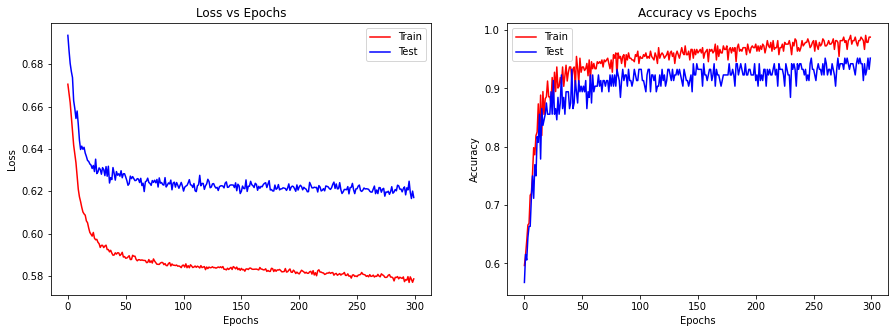

In [149]:
## Optimal Hyperparameters
DROPOUT = 0.4
LEARNING_RATE = 0.01
EPOCHS = 300
in_features = X_train.shape[1]
B1 = 0.05
out_features = 1 ## binary_classification
model = MLP(DROPOUT,in_features, out_features)
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(B1, 0.999)) 

train_losses = []
train_accuarcies = []
test_losses = []
test_accuarcies = []
for epoch in range(EPOCHS):
    
    ## training on train data
    out = model(X_train.float())
    loss = criterion(out.squeeze(),y_train)
    train_acc = accuracy(out.detach().cpu(),y_train.cpu())
    train_losses.append(loss.cpu().item())
    train_accuarcies.append(train_acc)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    ## evaluatin on test set
    with torch.no_grad():
        pred = model(X_test.float())
        test_loss = criterion(pred.squeeze(),y_test)
        test_acc = accuracy(pred.cpu(),y_test.cpu())
        test_losses.append(test_loss.cpu().item())
        test_accuarcies.append(test_acc)
    if (epoch+1)%100 == 0 or epoch ==0 :
        print(f"EPOCH = {(epoch+1):>3.0f},     Train loss = {(loss):>0.2f},    Train acc = {(train_acc):>0.2f},    Test loss = {(test_loss):>0.2f},    Test acc = {(test_acc):>0.2f}", )
        
        
## plotting accuracy and loss curve of training 
fig,ax = plt.subplots(1,2, figsize= (15,5))

ax[0].plot(train_losses, label = "Train", color = "red")
ax[0].plot(test_losses, label = "Test", color = 'blue')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss vs Epochs")
ax[0].legend()

ax[1].plot(train_accuarcies, label = "Train", color = "red")
ax[1].plot(test_accuarcies, label = "Test", color = 'blue')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy vs Epochs")
ax[1].legend()
fig.show()

## Saving optimal hyperparamerter tuned model 

In [150]:
torch.save(model, "MLP-model")

## Evaluation 

### Laoding saved optimal hyperparameter tuned model 

In [151]:
saved_model = torch.load("MLP-model")
saved_model.to(device)

MLP(
  (dropout): Dropout(p=0.4, inplace=False)
  (layer_1): Linear(in_features=16, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [152]:
saved_model.eval()
with torch.no_grad():
    train_preds = saved_model(X_train.float())
    train_preds = train_preds.squeeze().cpu().numpy().round().astype("int")
train_labels = y_train.cpu().numpy()
print(f"Train-Set Accuracy =  {(accuracy_score(train_labels,train_preds)*100):>0.2f}%  ")

Train-Set Accuracy =  99.10%  


In [153]:
saved_model.eval()
with torch.no_grad():
    valid_preds = saved_model(X_valid.float())
    valid_preds = valid_preds.squeeze().cpu().numpy().round().astype("int")
valid_labels = y_valid.cpu().numpy()
print(f"Validation-Set Accuracy =  {(accuracy_score(valid_labels,valid_preds)*100):>0.2f}%  ")

Validation-Set Accuracy =  96.43%  


In [154]:
saved_model.eval()
with torch.no_grad():
    test_preds = saved_model(X_test.float())
    test_preds = test_preds.squeeze().cpu().numpy().round().astype("int")
test_labels = y_test.cpu().numpy()
print(f"Test-Set Accuracy =  {(accuracy_score(test_labels,test_preds)*100):>0.2f}%  ")

Test-Set Accuracy =  95.19%  


### Classification Report

In [155]:
print(classification_report(train_labels, train_preds))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       131
         1.0       0.99      1.00      0.99       201

    accuracy                           0.99       332
   macro avg       0.99      0.99      0.99       332
weighted avg       0.99      0.99      0.99       332



In [156]:
print(classification_report(valid_labels, valid_preds))

              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93        23
         1.0       0.97      0.98      0.98        61

    accuracy                           0.96        84
   macro avg       0.96      0.95      0.95        84
weighted avg       0.96      0.96      0.96        84



In [157]:
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95        46
         1.0       0.95      0.97      0.96        58

    accuracy                           0.95       104
   macro avg       0.95      0.95      0.95       104
weighted avg       0.95      0.95      0.95       104



### Confusion Matrix 

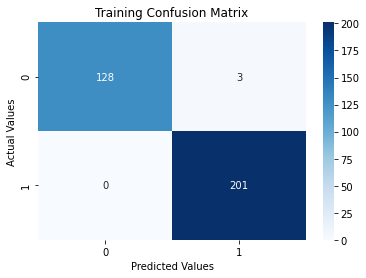

In [158]:
cf = confusion_matrix(train_labels, train_preds)

fig = sns.heatmap(cf,  annot=True, cmap='Blues', fmt='g')
fig.set_xlabel('Predicted Values')
fig.set_ylabel('Actual Values')
fig.set_title('Training Confusion Matrix')

plt.show()

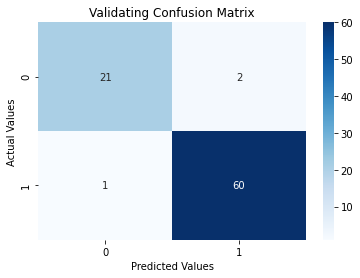

In [159]:
cf = confusion_matrix(valid_labels, valid_preds)

fig = sns.heatmap(cf,  annot=True, cmap='Blues')
fig.set_xlabel('Predicted Values')
fig.set_ylabel('Actual Values')
fig.set_title('Validating Confusion Matrix')

plt.show()

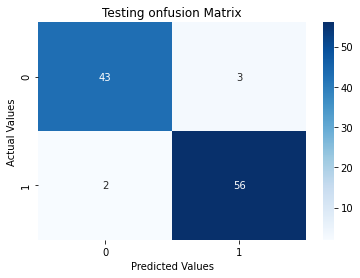

In [160]:
cf = confusion_matrix(test_labels, test_preds)

fig = sns.heatmap(cf,  annot=True, cmap='Blues')
fig.set_xlabel('Predicted Values')
fig.set_ylabel('Actual Values')
fig.set_title('Testing onfusion Matrix')

plt.show()

### ROC AUC Score

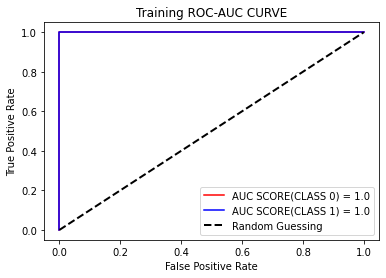

In [161]:
## generating prediction probabilities
model.eval()
with torch.no_grad():
    probs = model(X_train.float())
    probs = probs.squeeze().cpu().numpy()

neg_probs = []
for i in range(len(train_labels)):
    if train_labels[i] == 0 :
        neg_probs.append(1 - probs[i])
    else :
        neg_probs.append(probs[i])
## ploting auc-roc curve
neg_auc_score = roc_auc_score(train_labels, neg_probs)
auc_score = roc_auc_score(train_labels, probs)

fpr, tpr, _ = roc_curve(train_labels, neg_probs)
plt.plot(fpr, tpr, color ="red", label="AUC SCORE(CLASS 0) = "+str(round(neg_auc_score,2)))
fpr, tpr, _ = roc_curve(train_labels, probs)
plt.plot(fpr, tpr, color = "blue", label="AUC SCORE(CLASS 1) = "+str(round(auc_score,2)))
plt.plot(fpr, fpr, color = 'black', linestyle='dashed',lw=2 , label = 'Random Guessing')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Training ROC-AUC CURVE")
plt.legend()
plt.show()

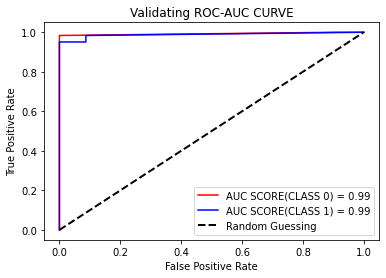

In [162]:
## generating prediction probabilities
model.eval()
with torch.no_grad():
    probs = model(X_valid.float())
    probs = probs.squeeze().cpu().numpy()

neg_probs = []
for i in range(len(valid_labels)):
    if valid_labels[i] == 0 :
        neg_probs.append(1 - probs[i])
    else :
        neg_probs.append(probs[i])
## ploting auc-roc curve
neg_auc_score = roc_auc_score(valid_labels, neg_probs)
auc_score = roc_auc_score(valid_labels, probs)

fpr, tpr, _ = roc_curve(valid_labels, neg_probs)
plt.plot(fpr, tpr, color ="red", label="AUC SCORE(CLASS 0) = "+str(round(neg_auc_score,2)))
fpr, tpr, _ = roc_curve(valid_labels, probs)
plt.plot(fpr, tpr, color = "blue", label="AUC SCORE(CLASS 1) = "+str(round(auc_score,2)))
plt.plot(fpr, fpr, color = 'black', linestyle='dashed',lw=2 , label = 'Random Guessing')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Validating ROC-AUC CURVE")
plt.legend()
plt.show()

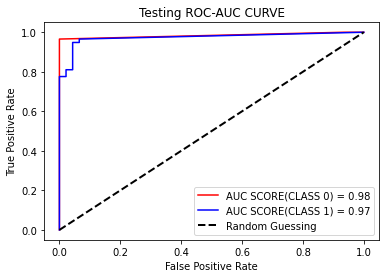

In [163]:
## generating prediction probabilities
model.eval()
with torch.no_grad():
    probs = model(X_test.float())
    probs = probs.squeeze().cpu().numpy()

neg_probs = []
for i in range(len(test_labels)):
    if test_labels[i] == 0 :
        neg_probs.append(1 - probs[i])
    else :
        neg_probs.append(probs[i])
## ploting auc-roc curve
neg_auc_score = roc_auc_score(test_labels, neg_probs)
auc_score = roc_auc_score(test_labels, probs)

fpr, tpr, _ = roc_curve(test_labels, neg_probs)
plt.plot(fpr, tpr, color ="red", label="AUC SCORE(CLASS 0) = "+str(round(neg_auc_score,2)))
fpr, tpr, _ = roc_curve(test_labels, probs)
plt.plot(fpr, tpr, color = "blue", label="AUC SCORE(CLASS 1) = "+str(round(auc_score,2)))
plt.plot(fpr, fpr, color = 'black', linestyle='dashed',lw=2 , label = 'Random Guessing')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Testing ROC-AUC CURVE")
plt.legend()
plt.show()